# SVM Classifier

In [1]:
from skimage.io import imread
from skimage.feature import hog
from skimage.color import rgb2grey
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import dill
import random
import os
import re
import cv2


* ### Data

In [2]:
# create df of name and label, and shuffle it
img_path = os.path.join(os.getcwd(), "data/raw_data/img_nparrays")
names = [f for f in os.listdir(img_path) if os.path.isfile(os.path.join(img_path, f))]
labels = [re.sub(r'\d+', '', name) for name in names]
paths = [os.path.join(img_path, f) for f in names]
dict_df = pd.DataFrame(zip(names,paths, labels), columns=['name','path', 'label'], dtype=str)
shuf_df = dict_df.sample(frac=1).reset_index(drop=True)
shuf_df.head()

,name,path,label
0,cardboard163,/Users/loaner/Documents/github/trash-classifie...,cardboard
1,trash423,/Users/loaner/Documents/github/trash-classifie...,trash
2,paper196,/Users/loaner/Documents/github/trash-classifie...,paper
3,metal267,/Users/loaner/Documents/github/trash-classifie...,metal
4,trash325,/Users/loaner/Documents/github/trash-classifie...,trash


In [3]:
dict_df.head()

,name,path,label
0,paper354,/Users/loaner/Documents/github/trash-classifie...,paper
1,cardboard188,/Users/loaner/Documents/github/trash-classifie...,cardboard
2,plastic389,/Users/loaner/Documents/github/trash-classifie...,plastic
3,paper166,/Users/loaner/Documents/github/trash-classifie...,paper
4,paper502,/Users/loaner/Documents/github/trash-classifie...,paper


* ### Feature Extraction

In [122]:
def extract_features(img):
    color_features = img.flatten()
    grey_image = rgb2grey(img)
    hog_features = hog(grey_image, block_norm='L2-Hys')
    flat_features = np.hstack((hog_features))
    return flat_features

In [125]:
test_img = dill.load(open(os.path.join(img_path,"trash233"),'rb'))
test_img.flatten().shape

(589824,)

In [130]:
extract_features(dill.load(open(os.path.join(img_path,"trash233"),'rb'))).shape

(231012,)

* ### Build SVM model

In [7]:
# result trial tracking
trials = []

In [ ]:
# backup

class batch_generator():
    def __init__(self, train_df, test_df, batch_size=200):
        self.train_df = train_df.reset_index(drop=True)
        self.test_df = test_df.reset_index(drop=True)
        self.batch_size = batch_size

#         self.test_size = int(self.total_size * test_ratio)
#         self.train_size = self.total_size - self.test_size
    
    def get_batches(self, df):
        shuf_df = df.sample(frac=1).reset_index(drop=True)
        for i in range(0, len(shuf_df), self.batch_size):
            paths = shuf_df['path'][i:i+self.batch_size]
            imgs = np.asarray([dill.load(open(p, 'rb')).flatten() for p in paths])
#             extracts = np.asarray([extract_features(dill.load(open(p, 'rb'))) for p in paths])
            labels = shuf_df['label'][i:i+self.batch_size]
            yield (imgs, labels)
    
    def train_batches(self):
        return self.get_batches(self.train_df)
    
    def test_batches(self):
        return self.get_batches(self.test_df)

#         return self.get_batches(self.train_size, self.total_size)
        
#     def train_batches(self):
#         for i in range(0, len(self.df[0:self.train_size]), self.batch_size):
#             paths = self.df['path'][i:i+self.batch_size]
#             imgs = np.asarray([dill.load(open(p, 'rb')).flatten() for p in paths])
# #             extracts = np.asarray([extract_features(dill.load(open(p, 'rb'))) for p in paths])
#             labels = self.df['label'][i:i+self.batch_size]
#             yield (imgs, labels)
    
#     def test_batches(self):
#         paths = self.df['path'][self.train_size:len(self.df)]
#         imgs = np.asarray([dill.load(open(p, 'rb')).flatten() for p in paths])
# #         extracts = np.asarray([extract_features(dill.load(open(p, 'rb'))) for p in paths])
#         labels = self.df['label'][self.train_size:len(self.df)]
#         return (imgs, labels) 


class batch_generator2():
    def __init__(self, df, batch_size=200, test_ratio=0.2):
        self.df = df
        self.total_size = len(self.df)
        self.batch_size = batch_size
        self.test_size = int(self.total_size * test_ratio)
        self.train_size = self.total_size - self.test_size
    
    def get_batches(self, df, start_index, end_index):
        shuf_df = df.sample(frac=1).reset_index(drop=True)
        for i in range(start_index, end_index, self.batch_size):
            paths = shuf_df['path'][i:i+self.batch_size]
            imgs = np.asarray([dill.load(open(p, 'rb')).flatten() for p in paths])
#             extracts = np.asarray([extract_features(dill.load(open(p, 'rb'))) for p in paths])
            labels = shuf_df['label'][i:i+self.batch_size]
            yield (imgs, labels)
    
    def train_batches(self):
        return self.get_batches(self.df, 0, self.train_size)
    
    def test_batches(self):
        return self.get_batches(self.df, self.train_size, len(self.df))

In [131]:
class batch_generator():
    def __init__(self, train_df, test_df, batch_size=200):
#         shuf_df = df.sample(frac=1).reset_index(drop=True)
        self.train_df = train_df.sample(frac=1).reset_index(drop=True)  # shuffle train set
        self.test_df = test_df.reset_index(drop=True)
        self.batch_size = batch_size

    def get_batches(self, df):
        for i in range(0, len(shuf_df), self.batch_size):
            paths = shuf_df['path'][i:i+self.batch_size]
#             imgs = np.asarray([dill.load(open(p, 'rb')).flatten() for p in paths])
            imgs = [extract_features(dill.load(open(p, 'rb'))) for p in paths]
            labels = shuf_df['label'][i:i+self.batch_size]
            yield (imgs, labels)
    
    def train_batches(self):
        return self.get_batches(self.train_df)
    
    def test_batches(self):
        paths = self.test_df['path']
#         imgs = np.asarray([dill.load(open(p, 'rb')).flatten() for p in paths])
        imgs = [extract_features(dill.load(open(p, 'rb'))) for p in paths]
        labels = self.test_df['label']
        return (imgs, labels) 
    
#     def test_batches(self):
#         return self.get_batches(self.test_df)

#         return self.get_batches(self.train_size, self.total_size)
        
#     def train_batches(self):
#         for i in range(0, len(self.df[0:self.train_size]), self.batch_size):
#             paths = self.df['path'][i:i+self.batch_size]
#             imgs = np.asarray([dill.load(open(p, 'rb')).flatten() for p in paths])
# #             extracts = np.asarray([extract_features(dill.load(open(p, 'rb'))) for p in paths])
#             labels = self.df['label'][i:i+self.batch_size]
#             yield (imgs, labels)
    
#     def test_batches(self):
#         paths = self.df['path'][self.train_size:len(self.df)]
#         imgs = np.asarray([dill.load(open(p, 'rb')).flatten() for p in paths])
# #         extracts = np.asarray([extract_features(dill.load(open(p, 'rb'))) for p in paths])
#         labels = self.df['label'][self.train_size:len(self.df)]
#         return (imgs, labels) 



class batch_generator2():
    def __init__(self, df, batch_size=200, test_ratio=0.2):
#         self.df = df.sample(frac=1).reset_index(drop=True)
        self.df = df
        self.total_size = len(self.df)
        self.batch_size = batch_size
        self.test_size = int(self.total_size * test_ratio)
        self.train_size = self.total_size - self.test_size
    
    def get_batches(self, df, start_index, end_index):
        for i in range(start_index, end_index, self.batch_size):
            paths = shuf_df['path'][i:i+self.batch_size]
            imgs = np.asarray([dill.load(open(p, 'rb')).flatten() for p in paths])
#             extracts = np.asarray([extract_features(dill.load(open(p, 'rb'))) for p in paths])
            labels = shuf_df['label'][i:i+self.batch_size]
            yield (imgs, labels)
    
    def train_batches(self):
        return self.get_batches(self.df, 0, self.train_size)
    
#     def test_batches(self):
#         return self.get_batches(self.df, self.train_size, len(self.df))
    
    def test_batches(self):
        paths = self.df['path'][self.train_size:len(self.df)]
        imgs = np.asarray([dill.load(open(p, 'rb')).flatten() for p in paths])
        labels = self.df['label'][self.train_size:len(self.df)]
        return (imgs, labels) 

In [132]:
# for method 1
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(dict_df, dict_df['label'], test_size=0.2)

clf = SGDClassifier(loss='hinge',shuffle=True, n_jobs=5, alpha=0.001)
# shuf_df = dict_df.sample(frac=1).reset_index(drop=True)

n_iter = 10
prog_val_scores = []
train_scores = []
for n in range(n_iter):
    counter = 0
    batch_gen = batch_generator(X_train_df, X_test_df, batch_size=200)

    for X_train_batch, y_train_batch in batch_gen.train_batches():
        if counter>0:
            prog_val_scores.append(clf.score(X_train_batch, y_train_batch))
        clf.partial_fit(X_train_batch, y_train_batch, classes=np.unique(y_train_batch))
        if counter>0:
            train_scores.append(clf.score(X_train_batch, y_train_batch))
        counter +=1

# y_pred = []
# y_true = []
# X_test = []

# for X_test_batch, y_test_batch in batch_gen.test_batches():
#     X_test.extend(X_test_batch)
#     y_pred.extend(clf.predict(X_test_batch))
#     y_true.extend(y_test_batch)


X_test, y_test = batch_gen.test_batches()
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

# adding to trial results
# trials.append(("batch_size=150, test_size=350, n=1 has 0, flatten",y_test, y_pred))

KeyboardInterrupt: 

In [115]:
from sklearn.model_selection import cross_val_score
cross_val_score(clf, X_test, y_test, cv=5)

array([0.31932773, 0.37815126, 0.29059829, 0.40517241, 0.40869565])

In [116]:
cross_val = _
cross_val_mean = cross_val.mean()

In [117]:
cross_val_mean

0.36038906963238915

In [113]:
# for method 2
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# X_train, X_test, y_train, y_test = train_test_split(dict_df, dict_df['label'], test_size=0.2)

clf = SGDClassifier(loss='hinge',shuffle=True, n_jobs=4)
# shuf_df = dict_df.sample(frac=1).reset_index(drop=True)

# manually increase the epochs (as partial_fit has max_iter set to 1)
n_iter = 10
for n in range(n_iter):
    shuf_df = X_train.sample(frac=1).reset_index(drop=True)
    batch_gen = batch_generator2(shuf_df, batch_size=150, test_ratio=0.1)
    for X_train_batch, y_train_batch in batch_gen.train_batches():
        clf.partial_fit(X_train_batch, y_train_batch, classes=np.unique(y_train_batch))

# y_pred = []
# y_test = []

# for X_test_batch, y_test_batch in batch_gen.test_batches():
#     y_pred_batch = clf.predict(X_test_batch)
#     y_pred.extend(y_pred_batch)
#     y_test.extend(y_test_batch)
    

X_test, y_test = batch_gen.test_batches()
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

# adding to trial results
# trials.append(("batch_size=150, test_size=350, n=1 has 0, flatten",y_test, y_pred))

              precision    recall  f1-score   support

   cardboard       1.00      0.19      0.33        36
       glass       0.67      0.18      0.28        34
       metal       0.88      0.22      0.35        32
       paper       0.30      0.98      0.46        61
     plastic       1.00      0.03      0.05        39
       trash       1.00      0.34      0.51        32

    accuracy                           0.39       234
   macro avg       0.81      0.32      0.33       234
weighted avg       0.75      0.39      0.34       234



              precision    recall  f1-score   support

   cardboard       0.88      0.20      0.33        74
       glass       1.00      0.02      0.04       104
       metal       0.00      0.00      0.00        81
       paper       0.24      0.99      0.39       127
     plastic       0.33      0.10      0.15       100
       trash       0.77      0.17      0.28       100

    accuracy                           0.29       586
   macro avg       0.54      0.25      0.20       586
weighted avg       0.53      0.29      0.21       586



/Users/loaner/.local/share/virtualenvs/trash-classifier-Blx31XfF/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Text(0, 0.5, 'score')

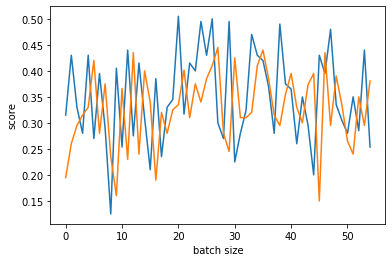

In [81]:
print(classification_report(y_true, y_pred))

plt.plot(train_scores, label="train score")
plt.plot(prog_val_scores, label="progressive validation score")
plt.xlabel("batch size")
plt.ylabel("score")
plt.xlim((0,500))
plt.legend(loc='best')

In [92]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, valid_scores = learning_curve(clf, X_test, y_true, \
                                                         train_sizes=range(50,500, 50), cv=5)

KeyboardInterrupt: 

In [ ]:
plt.figure()
plt.title("learning curve")

plt.xlabel("Training examples")
plt.ylabel("Score")

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)
# plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")

              precision    recall  f1-score   support

   cardboard       0.78      0.74      0.76        38
       glass       1.00      0.17      0.29        59
       metal       0.41      0.71      0.52        34
       paper       0.57      0.92      0.71        59
     plastic       0.86      0.13      0.23        46
       trash       0.60      0.88      0.71        64

    accuracy                           0.59       300
   macro avg       0.70      0.59      0.53       300
weighted avg       0.71      0.59      0.54       300



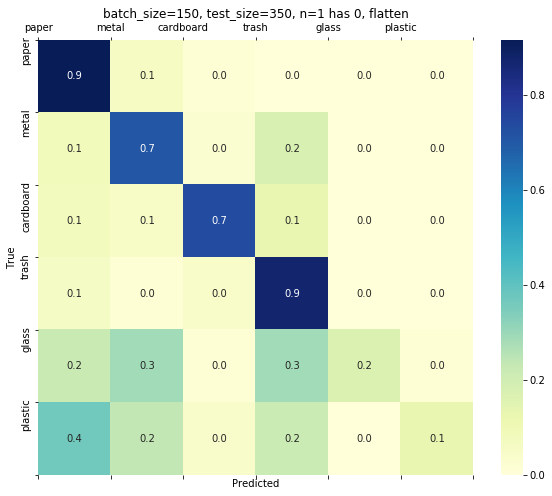

In [13]:
# results visulization
from sklearn.metrics import confusion_matrix
import seaborn as sns

desc, test_y, pred_y = trials[0]

print(classification_report(test_y, pred_y))

categories = ['paper','metal','cardboard','trash','glass','plastic']
cm = confusion_matrix(test_y, pred_y,labels=categories)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

df_cm = pd.DataFrame(cm,categories,categories)

fig = plt.figure(figsize=(10,8))
ax = sns.heatmap(df_cm,annot=True,fmt=".1f",cmap="YlGnBu")
cax = ax.matshow(cm)
plt.title(desc)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [132]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

# feature extraction
img_extract = [to_orb_desc(img) for img in mixed_imgs]

# split test and train sets
Img_train, Img_test, label_train, label_test = \
train_test_split(img_extract, testing_num_labels, test_size=0.2, random_state=109)

# train model
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']}
]
svc = svm.SVC()
svm_model = GridSearchCV(svc, param_grid)
svm_model.fit(Img_train, label_train)

label_pred = svm_model.predict(Img_test)
print(classification_report(label_test, label_pred))

/Users/loaner/.local/share/virtualenvs/trash-classifier-Blx31XfF/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/loaner/.local/share/virtualenvs/trash-classifier-Blx31XfF/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: setting an array element with a sequence.

* ### Feature reduction

In [30]:
# single image testing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

print('original shape: ', matrix_test.shape)

# scaling
ss = StandardScaler()
ss_trans = ss.fit_transform(matrix_test.reshape(-1,1))

# PCA
pca = PCA(n_components=1)
pca_trans = ss.transform(ss_trans)

# new shape
print('after transformation new shape is: ', pca_trans.shape)

original shape:  (2, 589824)
after transformation new shape is:  (1179648, 1)


In [31]:
pca_trans

array([[-4.59682663],
       [-4.62055739],
       [-4.63022548],
       ...,
       [-4.62231522],
       [-4.62934656],
       [-4.63901465]])